# MoViNet Tutorial

This notebook provides basic example code to build, run, and fine-tune [MoViNets (Mobile Video Networks)](https://arxiv.org/pdf/2103.11511.pdf).

Pretrained models are provided by [TensorFlow Hub](https://tfhub.dev/google/collections/movinet/) and the [TensorFlow Model Garden](https://github.com/tensorflow/models/tree/master/official/projects/movinet), trained on [Kinetics 600](https://deepmind.com/research/open-source/kinetics) for video action classification. All Models use TensorFlow 2 with Keras for inference and training.

The following steps will be performed:

1. [Running base model inference with TensorFlow Hub](#scrollTo=6g0tuFvf71S9&line=8&uniqifier=1)
2. [Running streaming model inference with TensorFlow Hub and plotting predictions](#scrollTo=ADrHPmwGcBZ5&line=4&uniqifier=1)
3. [Exporting a streaming model to TensorFlow Lite for mobile](#scrollTo=W3CLHvubvdSI&line=3&uniqifier=1)
4. [Fine-Tuning a base Model with the TensorFlow Model Garden](#scrollTo=_s-7bEoa3f8g&line=11&uniqifier=1)

![jumping jacks plot](https://storage.googleapis.com/tf_model_garden/vision/movinet/artifacts/jumpingjacks_plot.gif)

To generate video plots like the one above, see [section 2](#scrollTo=ADrHPmwGcBZ5&line=4&uniqifier=1).

## Setup

For inference on smaller models (A0-A2), CPU is sufficient for this Colab. For fine-tuning, it is recommended to run the models using GPUs.

To select a GPU in Colab, select `Runtime > Change runtime type > Hardware accelerator > GPU` dropdown in the top menu.

In [1]:
# Install packages

# tf-models-official is the stable Model Garden package
# tf-models-nightly includes latest changes
%pip --version
%pip install tensorflow
%pip install -U -q "tf-models-official"


# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (sudo apt update && sudo apt install -y ffmpeg)
%pip install -q mediapy
%pip install ipywidgets
%pip install jupyter notebook

pip 20.0.2 from /home/wldnjs/.venv/lib/python3.8/site-packages/pip (python 3.8)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 4.0 MB 21.0 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 103.6 MB/s eta 0:00:01
     |████████████████████████████████| 254 kB 116.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 74.7 MB/s eta 0:00:01
     |████████████████████████████████| 374 kB 83.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 8.1 MB/s s eta 0:00:01
     |████████████████████████████████| 84 kB 4.5 MB/s  eta 0:00:01
     |████████████████████████████████| 142 kB 87.2 MB/s eta 0:00:01
     |███████████████████████████████

In [1]:
%pip install pycuda

/home/wldnjs


SHELL=/bin/bash
PYTHONUNBUFFERED=1
WSL2_GUI_APPS_ENABLED=1
WSL_DISTRO_NAME=Ubuntu-20.04
ELECTRON_RUN_AS_NODE=1
VSCODE_AMD_ENTRYPOINT=vs/workbench/api/node/extensionHostProcess
NAME=DESKTOP-T9K23CB
PWD=/home/wldnjs
LOGNAME=wldnjs
PYDEVD_IPYTHON_COMPATIBLE_DEBUGGING=1
_=/usr/bin/printenv
HOME=/home/wldnjs
LANG=C.UTF-8
WSL_INTEROP=/run/WSL/544_interop
LS_COLORS=rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:*.zip=01;31:*.z=01;31:*.dz=01;31:*.gz=01;31:*.lrz=01;31:*.lz=01;31:*.lzo=01;31:*.xz=01;31:*.zst=01;31:*.tzst=01;31:*.bz2=01;31:*.bz=01;31:*.tbz=01;31:*.tbz2=01;31:*.tz=01;31:*.deb=01;31:*.rpm=01;31:*.jar=01;31:*.war=01;31:*.ear=01;31:*.sar=01;31:*.rar=01;31:*.alz=01;31:*.ace=01;31:*.zoo=01;31:*.cpio=01;31:*.7z=01;31:*.r

In [1]:
# Run imports
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tqdm
import absl.logging
from tensorflow.python.client import device_lib
tf.get_logger().setLevel('ERROR')
absl.logging.set_verbosity(absl.logging.ERROR)
mpl.rcParams.update({
    'font.size': 10,
})
device_lib.list_local_devices()
print(tf.version.VERSION)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(
      gpus[0],
      [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs, ", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

2023-08-29 22:27:48.426347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 22:27:49.579976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0
1 Physical GPUs,  1 Logical GPUs


2023-08-29 22:27:51.794618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 22:27:52.052697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 22:27:52.053085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 22:27:53.412993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 22:27:53.413230: I tensorflow/compile

Run the cell below to define helper functions and create variables.

In [2]:
#@title Run this cell to set up some helper code.

# Download Kinetics 600 label map
!wget https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt -O labels.txt -q

with tf.io.gfile.GFile('labels.txt') as f:
  lines = f.readlines()
  KINETICS_600_LABELS_LIST = [line.strip() for line in lines]
  KINETICS_600_LABELS = tf.constant(KINETICS_600_LABELS_LIST)

def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

def load_movinet_from_hub(model_id, model_mode, hub_version=3):
  """Loads a MoViNet model from TF Hub."""
  hub_url = f'https://tfhub.dev/tensorflow/movinet/{model_id}/{model_mode}/kinetics-600/classification/{hub_version}'

  encoder = hub.KerasLayer(hub_url, trainable=True)

  inputs = tf.keras.layers.Input(
      shape=[None, None, None, 3],
      dtype=tf.float32)

  if model_mode == 'base':
    inputs = dict(image=inputs)
  else:
    # Define the state inputs, which is a dict that maps state names to tensors.
    init_states_fn = encoder.resolved_object.signatures['init_states']
    state_shapes = {
        name: ([s if s > 0 else None for s in state.shape], state.dtype)
        for name, state in init_states_fn(tf.constant([0, 0, 0, 0, 3])).items()
    }
    states_input = {
        name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
        for name, (shape, dtype) in state_shapes.items()
    }

    # The inputs to the model are the states and the video
    inputs = {**states_input, 'image': inputs}

  # Output shape: [batch_size, 600]
  outputs = encoder(inputs)

  model = tf.keras.Model(inputs, outputs)
  model.build([1, 1, 1, 1, 3])

  return model

# Download example gif
!wget https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif -O jumpingjack.gif -q

def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS_LIST):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]

  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames

  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])

  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')

  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image, (fig, ax, ax2)

def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  video_fps = 8.
  figure_height = 500
  steps = video.shape[0]
  duration = steps / video_fps

  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image, _ = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

## Running Base Model Inference with TensorFlow Hub

We will load MoViNet-A2-Base from TensorFlow Hub as part of the [MoViNet collection](https://tfhub.dev/google/collections/movinet/).

The following code will:

- Load a MoViNet KerasLayer from [tfhub.dev](https://tfhub.dev).
- Wrap the layer in a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
- Load an example gif as a video.
- Classify the video and print the top-5 predicted classes.

In [3]:
model = load_movinet_from_hub('a2', 'base', hub_version=3)

To provide a simple example video for classification, we can load a short gif of jumping jacks being performed.

![jumping jacks](https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif)

Attribution: Footage shared by [Coach Bobby Bluford](https://www.youtube.com/watch?v=-AxHpj-EuPg) on YouTube under the CC-BY license.

In [4]:
video = load_gif('jumpingjack.gif', image_size=(172, 172))

# Show video
print(video.shape)
media.show_video(video.numpy(), fps=5)

(13, 172, 172, 3)


In [5]:
# Run the model on the video and output the top 5 predictions
outputs = predict_top_k(model, video)

for label, prob in outputs:
  print(label, prob)

2023-08-29 22:28:10.634794: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5d180021a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-29 22:28:10.634845: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2023-08-29 22:28:12.387519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-29 22:28:14.698281: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 15s 15s/step
jumping jacks 0.9166437
zumba 0.016020728
doing aerobics 0.008053943
dancing charleston 0.0060835956
lunge 0.0035062756


## Run Streaming Model Inference with TensorFlow Hub and Plot Predictions

We will load MoViNet-A0-Stream from TensorFlow Hub as part of the [MoViNet collection](https://tfhub.dev/google/collections/movinet/).

The following code will:

- Load a MoViNet model from [tfhub.dev](https://tfhub.dev).
- Classify an example video and plot the streaming predictions over time.

In [6]:
model = load_movinet_from_hub('a2', 'stream', hub_version=3)

# Create initial states for the stream model
init_states_fn = model.layers[-1].resolved_object.signatures['init_states']
init_states = init_states_fn(tf.shape(video[tf.newaxis]))

In [7]:
# Insert your video clip here
video = load_gif('jumpingjack.gif', image_size=(172, 172))
clips = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for clip in tqdm.tqdm(clips):
  # Input shape: [1, 1, 172, 172, 3]
  logits, states = model.predict({**states, 'image': clip}, verbose=0)
  all_logits.append(logits)

logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)

final_probs = probs[-1]
top_k = get_top_k(final_probs)
print()
for label, prob in top_k:
  print(label, prob)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


jumping jacks 0.9998122
zumba 0.00011835529
doing aerobics 3.337584e-05
dancing charleston 4.9820073e-06
finger snapping 3.867371e-06


In [8]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8.)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


In [9]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=3)

## Export a Streaming Model to TensorFlow Lite for Mobile

We will convert a MoViNet-A0-Stream model to [TensorFlow Lite](https://www.tensorflow.org/lite).

The following code will:
- Load a MoViNet-A0-Stream model.
- Convert the model to TF Lite.
- Run inference on an example video using the Python interpreter.

In [10]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

In [11]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=600,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)


# Extract pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
!tar -xvf movinet_a0_stream.tar.gz

checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_stream/
movinet_a0_stream/ckpt-1.data-00000-of-00001
movinet_a0_stream/ckpt-1.index
movinet_a0_stream/checkpoint


In [12]:
# Export to saved model
saved_model_dir = 'model'
tflite_filename = 'model.tflite'
input_shape = [1, 1, 172, 172, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)

In [13]:
# Convert to TF Lite
print(saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)

# Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename)
runner = interpreter.get_signature_runner()

init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
}
del init_states['image']

model


2023-08-29 22:30:31.339035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-29 22:30:31.339084: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-29 22:30:31.340132: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model
2023-08-29 22:30:31.429040: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-08-29 22:30:31.429075: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: model
2023-08-29 22:30:31.715795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-08-29 22:30:31.774213: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-29 22:30:32.559994: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model
2023-08-29 22:30:33.071017: I tensorflow

In [14]:
# Insert your video clip here
video = load_gif('jumpingjack.gif', image_size=(172, 172))
clips = tf.split(video[tf.newaxis], video.shape[0], axis=1)

# To run on a video, pass in one frame at a time
states = init_states
for clip in clips:
  # Input shape: [1, 1, 172, 172, 3]
  outputs = runner(**states, image=clip)
  logits = outputs.pop('logits')[0]
  states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
for label, prob in top_k:
  print(label, prob)


jumping jacks 0.9733523
jogging 0.0032490497
stretching arm 0.002780116
riding unicycle 0.0019377903
passing soccer ball 0.0016310464


## Fine-Tune a Base Model with the TensorFlow Model Garden

We will Fine-tune MoViNet-A0-Base on [UCF-101](https://www.crcv.ucf.edu/research/data-sets/ucf101/).

The following code will:

- Load the UCF-101 dataset with [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/ucf101).
- Create a simple [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) pipeline for training and evaluation.
- Display some example videos from the dataset.
- Build a MoViNet model and load pretrained weights.
- Fine-tune the final classifier layers on UCF-101 and evaluate accuracy on the validation set.

### Load the UCF-101 Dataset with TensorFlow Datasets

Calling `download_and_prepare()` will automatically download the dataset. This step may take up to 1 hour depending on the download and extraction speed. After downloading, the next cell will output information about the dataset.

In [15]:
# Run imports
import tensorflow_datasets as tfds

from official.vision.configs import video_classification
from official.projects.movinet.configs import movinet as movinet_configs
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_layers
from official.projects.movinet.modeling import movinet_model

In [28]:
dataset_name = 'ucf101'

builder = tfds.builder(dataset_name)

config = tfds.download.DownloadConfig(verify_ssl=False)
builder.download_and_prepare(download_config=config)

In [30]:
num_classes = builder.info.features['label'].num_classes
num_examples = {
    name: split.num_examples
    for name, split in builder.info.splits.items()
}

print('Number of classes:', num_classes)
print('Number of examples for train:', num_examples['train'])
print('Number of examples for test:', num_examples['test'])
print()

builder.info

Number of classes: 101
Number of examples for train: 9537
Number of examples for test: 3783



tfds.core.DatasetInfo(
    name='ucf101',
    full_name='ucf101/ucf101_1_256/2.0.0',
    description="""
    A 101-label video classification dataset.
    """,
    config_description="""
    256x256 UCF with the first action recognition split.
    """,
    homepage='https://www.crcv.ucf.edu/data-sets/ucf101/',
    data_path='/home/wldnjs/tensorflow_datasets/ucf101/ucf101_1_256/2.0.0',
    file_format=tfrecord,
    download_size=6.48 GiB,
    dataset_size=7.41 GiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
        'video': Video(Image(shape=(256, 256, 3), dtype=uint8)),
    }),
    supervised_keys=None,
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=3783, num_shards=32>,
        'train': <SplitInfo num_examples=9537, num_shards=64>,
    },
    citation="""@article{DBLP:journals/corr/abs-1212-0402,
      author    = {Khurram Soomro and
                   Amir Roshan Zamir and
                   Muba

In [31]:
# Build the training and evaluation datasets.

batch_size = 2
num_frames = 4
frame_stride = 10
resolution = 172

def format_features(features):
  video = features['video']
  video = video[:, ::frame_stride]
  video = video[:, :num_frames]

  video = tf.reshape(video, [-1, video.shape[2], video.shape[3], 3])
  video = tf.image.resize(video, (resolution, resolution))
  video = tf.reshape(video, [-1, num_frames, resolution, resolution, 3])
  video = tf.cast(video, tf.float32) / 255.

  label = tf.one_hot(features['label'], num_classes)
  return (video, label)

train_dataset = builder.as_dataset(
    split='train',
    batch_size=batch_size,
    shuffle_files=True)
train_dataset = train_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(2)

test_dataset = builder.as_dataset(
    split='test',
    batch_size=batch_size)
test_dataset = test_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=True)
test_dataset = test_dataset.prefetch(2)

Display some example videos from the dataset.

,

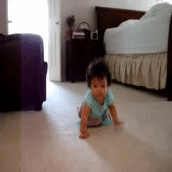
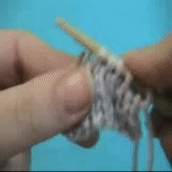

In [32]:
videos, labels = next(iter(train_dataset))
media.show_videos(videos.numpy(), codec='gif', fps=5)

### Build MoViNet-A0-Base and Load Pretrained Weights

Here we create a MoViNet model using the open source code provided in [official/projects/movinet](https://github.com/tensorflow/models/tree/master/official/projects/movinet) and load the pretrained weights. Here we freeze the all layers except the final classifier head to speed up fine-tuning.

In [40]:
model_id = 'a0'

tf.keras.backend.clear_session()

backbone = movinet.Movinet(
    model_id=model_id,
    causal=False,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding
)
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600, output_states=True)
# model.build([1, 1, 1, 1, 3])

# Load pretrained weights
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
# !tar -xvf movinet_a0_base.tar.gz
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
# !tar -xvf movinet_a0_stream.tar.gz

checkpoint_dir = 'movinet_a0_base'
# checkpoint_dir = 'movinet_a0_stream'

checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

def build_classifier(backbone, num_classes, freeze_backbone=False):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  if freeze_backbone:
    for layer in model.layers[:-1]:
      layer.trainable = False
    model.layers[-1].trainable = True

  return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.
model = build_classifier(backbone, num_classes, freeze_backbone=True)

AssertionError: Found 170 Python objects that were not bound to checkpointed values, likely due to changes in the Python program. Showing 10 of 170 unmatched objects: [<tf.Variable 'block3_layer1/bneck/se/se_expand/conv2d/conv2d_2/bias:0' shape=(184,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>, <tf.Variable 'block0_layer0/bneck/skip/skip_project/conv2d/conv2d_4/kernel:0' shape=(1, 1, 8, 8) dtype=float32, numpy=
array([[[[ 0.91453254,  0.1893307 , -0.39915067, -0.4076248 ,
           0.782223  , -0.33421087,  0.51445514, -0.45848286],
         [ 0.2784893 , -1.1072615 , -0.1257072 ,  0.5643713 ,
           0.34991536, -0.15819323,  0.01273316, -0.79047936],
         [ 0.7846378 ,  0.12714477, -0.9214451 ,  0.9854258 ,
          -0.5033334 , -0.07897564, -0.6908259 ,  0.5485671 ],
         [ 0.19031921, -0.74273425, -0.47881773,  1.0194997 ,
          -0.5542138 , -0.21193287,  0.9380149 ,  0.46997252],
         [-0.5153445 ,  0.6258736 ,  0.04240167, -0.17064898,
           0.34449598, -0.58254653, -0.26792336, -0.47311702],
         [-0.8811214 , -0.01738349, -0.16982806,  0.08686945,
          -0.48050034,  0.5084606 , -0.87320447,  0.69018507],
         [-0.8586288 , -0.22169311, -0.22193274,  0.3064498 ,
           0.94970065, -0.76539445,  0.26744682,  0.3092718 ],
         [ 0.4418008 ,  0.5661967 ,  0.53929675,  0.11316212,
          -0.83931565,  0.09564767,  0.09462198,  0.70833653]]]],
      dtype=float32)>, <tf.Variable 'block4_layer0/bneck/se/se_expand/conv2d/conv2d_2/bias:0' shape=(384,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'block0_layer0/bneck/se/se_reduce/conv2d/conv2d_1/kernel:0' shape=(1, 1, 48, 16) dtype=float32, numpy=
array([[[[ 0.08561159,  0.28819364, -0.13937923,  0.00340183,
           0.22207314,  0.18598641,  0.12901774,  0.05627904,
           0.20296966,  0.46240136, -0.36752504,  0.09826731,
           0.16673408,  0.0318625 ,  0.1521663 ,  0.17170183],
         [ 0.28365272, -0.26987204,  0.02694583,  0.25341076,
           0.21311313,  0.23997836,  0.18393093, -0.04089561,
          -0.20493138,  0.31603536, -0.28449172,  0.03793601,
          -0.00538839, -0.41014674,  0.30295667, -0.08737483],
         [ 0.3583531 ,  0.12620336, -0.31453055, -0.19608812,
          -0.15137109, -0.1756436 , -0.18028064,  0.27622777,
          -0.30334002, -0.27240497,  0.29070893,  0.07053783,
          -0.31331193, -0.01523276,  0.04324702, -0.11633832],
         [ 0.38625404,  0.08344669, -0.02132136,  0.01555832,
          -0.32230008, -0.16953751, -0.07999084, -0.21630497,
          -0.15598415,  0.03755495, -0.2691806 ,  0.17338598,
           0.45802   ,  0.15222505, -0.14881885, -0.09852422],
         [-0.05059989, -0.3925453 , -0.13260995,  0.12251814,
           0.20783935,  0.05482177,  0.04485551, -0.10444006,
           0.264314  ,  0.01677193, -0.10221855,  0.21672152,
          -0.42969927, -0.23254761,  0.31905127, -0.03969165],
         [-0.22943555,  0.01329149,  0.15080497, -0.16300589,
           0.12970553,  0.07401735, -0.1535633 , -0.37960032,
          -0.17328638, -0.19508451, -0.3197845 , -0.3409062 ,
           0.23282835, -0.04847023, -0.16948326,  0.25264847],
         [-0.21466506,  0.18128504,  0.32531145, -0.14264016,
          -0.25904465,  0.1922734 ,  0.30595136,  0.33352438,
           0.13282871,  0.01668362,  0.090596  ,  0.09677939,
          -0.05517441,  0.01211483,  0.00316544,  0.1322295 ],
         [ 0.0325427 ,  0.05025495,  0.17746964, -0.06666568,
           0.28524992,  0.0587617 ,  0.05301867, -0.11881126,
          -0.2905394 ,  0.3074145 , -0.3543995 , -0.13203445,
           0.20890558, -0.3949609 ,  0.37388545,  0.21314044],
         [-0.22076151,  0.37076464, -0.0423514 , -0.06335911,
          -0.24808007,  0.13156074, -0.34159845, -0.09323835,
          -0.03611694,  0.08959829, -0.06080798, -0.03212405,
           0.07048243,  0.12744099,  0.26650047, -0.31019318],
         [-0.00434748, -0.02944367,  0.17860606, -0.21763508,
           0.09880421,  0.02175898,  0.4573772 , -0.36518216,
           0.16478834, -0.26048383, -0.00526223, -0.00464315,
          -0.11946399, -0.05792579,  0.09126824,  0.31802276],
         [ 0.26129618,  0.03963347, -0.02061361, -0.26579097,
          -0.44775346, -0.23500715,  0.22674441,  0.00978601,
           0.19576408, -0.01841269,  0.01941563,  0.05467818,
           0.03506416,  0.09762095, -0.2010334 ,  0.08016113],
         [ 0.36309052, -0.11627936,  0.26585656, -0.16701369,
          -0.18013325, -0.09330897, -0.01385157, -0.34490636,
          -0.3200295 ,  0.25174743, -0.1441692 ,  0.1344041 ,
           0.07667162,  0.35993147, -0.16374135,  0.09557877],
         [-0.16161814, -0.15160583,  0.18225466, -0.03145236,
          -0.18149982, -0.27609983, -0.13868967, -0.30853778,
          -0.08232636, -0.04892527,  0.0860599 , -0.19547287,
           0.27699676,  0.13508421, -0.0331938 ,  0.30518416],
         [ 0.16747443,  0.21848364,  0.07671323,  0.20099701,
          -0.17773429, -0.06155255,  0.31107625,  0.03510212,
           0.29876846,  0.08324222,  0.14446452,  0.06918372,
          -0.16814777, -0.11376182,  0.11511895,  0.25792855],
         [-0.21956722,  0.29073328, -0.05103722, -0.03113941,
          -0.1953659 ,  0.05539732, -0.05789022, -0.25831825,
           0.22270663,  0.25883237,  0.2622656 ,  0.08972117,
          -0.36495507, -0.12874854,  0.29066917,  0.21010503],
         [-0.3208177 , -0.29303518,  0.24176201, -0.06958231,
           0.12408309,  0.17420249, -0.06684979, -0.12436944,
          -0.2324667 , -0.13500805,  0.20478879,  0.0091913 ,
           0.3175016 , -0.33016267,  0.27567226, -0.03835179],
         [ 0.24299307,  0.09743322,  0.12719715,  0.08187653,
           0.00325611,  0.08613981,  0.14753926, -0.14598785,
          -0.16967036,  0.03850829, -0.37502986, -0.14184926,
          -0.09844923, -0.34883115,  0.27066287,  0.18026203],
         [-0.08329882,  0.34762844, -0.16454889,  0.2652726 ,
          -0.05697559,  0.08858012,  0.13919802, -0.08458634,
          -0.1896351 ,  0.00776996,  0.03648545, -0.19008921,
           0.21392688,  0.02859127,  0.08075675,  0.11357522],
         [-0.10093592,  0.19199906,  0.07598998,  0.02941109,
          -0.07493202,  0.2173306 ,  0.1376721 ,  0.20260015,
           0.12093373, -0.13003264, -0.29006872,  0.29529676,
          -0.2958771 , -0.08532128,  0.02528186, -0.3834571 ],
         [-0.00358546,  0.07907368,  0.03763812, -0.08943994,
           0.12317846,  0.24445955, -0.14361538,  0.09254067,
          -0.43549624,  0.01516267, -0.0751235 ,  0.02848756,
          -0.31687424,  0.15720393, -0.42425486,  0.3087201 ],
         [-0.03918421,  0.36608067,  0.173269  ,  0.17219798,
           0.20254631,  0.04524273, -0.17213951,  0.07651933,
          -0.07609123,  0.1846986 ,  0.17827392, -0.38840398,
           0.43775994, -0.07062556,  0.26026037,  0.0063666 ],
         [ 0.09325653, -0.30630606,  0.39744338,  0.20400703,
          -0.14004427,  0.2457102 ,  0.12592913,  0.32486883,
          -0.12959255,  0.1398284 ,  0.04532871, -0.08445562,
          -0.20517197,  0.13000205,  0.15300548, -0.06914905],
         [ 0.35330442, -0.16751489, -0.11198092, -0.23268743,
          -0.03800064, -0.34227464,  0.32506213,  0.41999885,
           0.11148738,  0.10612602, -0.13905077,  0.04862019,
           0.07521597, -0.41940472, -0.14867248, -0.18709552],
         [-0.1125754 ,  0.0376788 , -0.05092073,  0.05794311,
           0.2523276 ,  0.06364039, -0.02293367, -0.07923436,
           0.30340073,  0.44241574, -0.38300112, -0.19257617,
           0.32616508, -0.16595453, -0.09174177, -0.4170419 ],
         [ 0.3884437 ,  0.05445201, -0.18376197, -0.16628186,
          -0.09815034, -0.20134822,  0.20119171, -0.4467924 ,
          -0.15254048, -0.06247779, -0.05301552, -0.09056944,
           0.05484537,  0.1983591 ,  0.14326821,  0.30838367],
         [ 0.18966165,  0.3761971 , -0.1878781 , -0.31294048,
           0.16496673, -0.10672659, -0.03147711,  0.23517443,
          -0.09663074, -0.16421026,  0.27215937, -0.35959914,
           0.15905134, -0.10136528, -0.15618174,  0.24787912],
         [-0.20809391, -0.4056262 ,  0.01418804,  0.00479182,
           0.10280237, -0.1540279 ,  0.16675244,  0.1939004 ,
          -0.17791411, -0.20985925, -0.20432682, -0.03751066,
           0.1179447 , -0.403165  , -0.3281504 ,  0.12005559],
         [-0.01748731, -0.274579  , -0.04167569,  0.01165722,
           0.01530619, -0.35942274, -0.25295934,  0.03655837,
           0.29435185,  0.29404828,  0.11934333, -0.20352967,
          -0.04730883,  0.17165783, -0.1954735 ,  0.01325848],
         [-0.24939331,  0.17247242,  0.08620743, -0.30680522,
           0.3517269 , -0.21309707, -0.21677361, -0.05962123,
          -0.24273875, -0.3837173 ,  0.14835791, -0.17285523,
          -0.174725  ,  0.24655586,  0.07992132,  0.0780668 ],
         [-0.06281082, -0.37036788,  0.44562122, -0.32669002,
          -0.09489599,  0.12409366,  0.25714326,  0.03028367,
           0.3959501 ,  0.14761135, -0.07241089,  0.4267347 ,
           0.14249358,  0.02185891, -0.05003957, -0.20895629],
         [ 0.1455976 ,  0.23047526,  0.11412279, -0.01429417,
          -0.14737219,  0.08516361, -0.04792048,  0.27704954,
           0.00556031, -0.25333807,  0.17937994, -0.04273709,
          -0.1086198 , -0.08515412,  0.38672435,  0.22776224],
         [-0.26413766, -0.03891533, -0.20992742,  0.2698858 ,
          -0.12071846, -0.1954302 ,  0.19812462,  0.04681924,
          -0.02787134, -0.09260188, -0.28418046, -0.19488212,
           0.40925822,  0.2276468 ,  0.02425615,  0.04255067],
         [-0.37101683, -0.0534253 ,  0.31193626, -0.12713602,
          -0.2360703 , -0.26714128, -0.23439595, -0.20210893,
          -0.30072674,  0.05555904, -0.14106815, -0.01592983,
           0.09307379, -0.24853256,  0.00475791, -0.23421007],
         [ 0.1839512 , -0.14037183,  0.27846044,  0.05739268,
          -0.16235012, -0.19903629, -0.02313468,  0.0898246 ,
          -0.15906109, -0.05946106,  0.4640258 , -0.45853215,
          -0.31321272,  0.00834176,  0.10056517,  0.01818792],
         [-0.09159043, -0.20005782, -0.1463339 ,  0.14128412,
           0.2755591 , -0.13331895,  0.02195524, -0.18133917,
          -0.20417935, -0.01231452, -0.17364947, -0.06969006,
          -0.36316773,  0.13676642, -0.2913044 , -0.03253323],
         [-0.15850674,  0.19095638,  0.00347088, -0.16004238,
           0.13168256,  0.1348279 , -0.00859826,  0.1711011 ,
           0.1329497 , -0.05967947,  0.3186455 ,  0.24978162,
          -0.14953287, -0.325608  , -0.1773204 ,  0.0142694 ],
         [ 0.08585155, -0.37595218, -0.14184126, -0.29691792,
           0.20799853,  0.0174068 , -0.21265824, -0.11768236,
           0.4198689 , -0.00080196,  0.10335033, -0.02620585,
           0.12837833,  0.10294703, -0.15425432,  0.093266  ],
         [ 0.17429337,  0.140867  ,  0.02090683,  0.09292454,
          -0.09391888,  0.12416683,  0.04770283, -0.10111733,
           0.10785096, -0.10246632,  0.05519496, -0.188269  ,
          -0.08532317, -0.23691377, -0.01039025,  0.06060165],
         [-0.03735504,  0.10473738,  0.05133119,  0.17010063,
          -0.16180117, -0.09939096,  0.09896965, -0.04304725,
           0.20642737,  0.2169563 , -0.07001535, -0.01409413,
          -0.22542794, -0.35667068,  0.33124202, -0.04410527],
         [ 0.08711982,  0.16841565,  0.21479993, -0.12408332,
          -0.01481158,  0.2020933 , -0.31432822,  0.15959062,
           0.17496786,  0.11958308,  0.13747565, -0.23360991,
          -0.05026063,  0.05794534,  0.26656798, -0.12619945],
         [ 0.05415804, -0.21818246,  0.12306181,  0.07131133,
          -0.33819023, -0.0604215 , -0.14568311,  0.06066657,
           0.15863477, -0.23742095, -0.08704203, -0.03516839,
          -0.0031097 , -0.17629021,  0.05636409, -0.28606805],
         [ 0.3002477 ,  0.05353424, -0.05743233,  0.2215435 ,
          -0.3065081 , -0.05144152, -0.12927899, -0.03094028,
           0.23692253,  0.07221881, -0.07564791,  0.1779725 ,
          -0.12274474, -0.03736296, -0.29611072, -0.41685328],
         [-0.03928364,  0.13547121,  0.44336206, -0.2461765 ,
          -0.17185126, -0.09767894,  0.13427025, -0.00598519,
          -0.23738311,  0.07957534, -0.31761017,  0.39447242,
          -0.08291002,  0.06377295,  0.29832035,  0.07166   ],
         [ 0.26400074, -0.1167962 , -0.23083869, -0.13646865,
          -0.18935631, -0.22111265,  0.39839855, -0.15516172,
          -0.18678339, -0.06337905, -0.07694189,  0.08661433,
           0.17333978, -0.29199532, -0.02011766, -0.19854341],
         [-0.08036537,  0.11185377,  0.07697651,  0.0322829 ,
          -0.04855709, -0.19159403,  0.33456823, -0.03761188,
          -0.27534676, -0.25594893, -0.26356596,  0.29100987,
           0.17767294,  0.33351773, -0.3124773 ,  0.03352359],
         [-0.4336    ,  0.09956654,  0.00595975, -0.2650501 ,
           0.3643385 ,  0.28539273, -0.11812261,  0.12102744,
          -0.23053506,  0.19024621, -0.3316974 , -0.05242921,
           0.02026732,  0.09037232, -0.10248186, -0.15997584],
         [-0.3068394 , -0.10296726, -0.09158862,  0.12953658,
          -0.0052787 , -0.45551324, -0.0804546 , -0.17383002,
           0.10228565,  0.07712024,  0.21455108,  0.04323897,
           0.11716406,  0.00559255,  0.20541424,  0.04698431],
         [ 0.10634521, -0.00224785, -0.1020362 ,  0.07027003,
           0.06896918, -0.2372252 , -0.08431827,  0.43027538,
           0.14040083, -0.44732478,  0.00487148,  0.41593492,
          -0.10483623,  0.16147968, -0.33636007,  0.11073475]]]],
      dtype=float32)>, <tf.Variable 'block1_layer0/bneck/feature/conv2d/depthwise_conv2d/depthwise_kernel:0' shape=(3, 3, 80, 1) dtype=float32, numpy=
array([[[[ 1.95541289e-02],
         [-6.41798452e-02],
         [-1.74813494e-02],
         [-1.91354100e-02],
         [ 1.63845532e-02],
         [ 6.98164478e-02],
         [ 9.52312574e-02],
         [ 3.97812650e-02],
         [-7.13517098e-03],
         [-9.00300071e-02],
         [ 8.20861459e-02],
         [ 2.29943227e-02],
         [ 8.60659853e-02],
         [ 1.09240994e-01],
         [-1.48466201e-02],
         [ 6.91499095e-03],
         [ 2.01866087e-02],
         [ 1.83393862e-02],
         [-7.09120259e-02],
         [ 7.48288333e-02],
         [ 3.63527215e-03],
         [-7.89786056e-02],
         [ 5.94856106e-02],
         [-4.46592364e-03],
         [ 5.44207059e-02],
         [ 1.03213191e-02],
         [-2.87204818e-03],
         [-1.60765159e-03],
         [-1.09738022e-01],
         [-3.04812919e-02],
         [-3.22591490e-03],
         [-6.84926212e-02],
         [-3.63913663e-02],
         [ 1.00322582e-01],
         [-5.20959236e-02],
         [-9.05968770e-02],
         [-1.90260131e-02],
         [-7.79735148e-02],
         [ 9.39791575e-02],
         [-5.06168418e-03],
         [ 1.55652324e-02],
         [ 2.49121599e-02],
         [ 3.51903699e-02],
         [-2.27882378e-02],
         [-9.53816697e-02],
         [ 5.00791483e-02],
         [ 5.09253761e-04],
         [ 6.52035549e-02],
         [ 4.08693179e-02],
         [ 2.50050910e-02],
         [-2.62123756e-02],
         [-7.36476406e-02],
         [-8.15389752e-02],
         [-3.49824093e-02],
         [ 4.59231958e-02],
         [-6.35579154e-02],
         [ 1.57977715e-02],
         [-3.81302387e-02],
         [ 1.14037924e-01],
         [-1.80474501e-02],
         [-1.50692575e-02],
         [ 5.73670212e-03],
         [-2.37264391e-02],
         [-8.33353549e-02],
         [ 1.81830651e-03],
         [-9.03199613e-02],
         [ 8.10344294e-02],
         [ 1.98777523e-02],
         [-2.84459945e-02],
         [ 1.26773110e-02],
         [ 6.16858527e-02],
         [ 2.47052801e-03],
         [ 6.36709481e-02],
         [ 3.67087200e-02],
         [-5.84245548e-02],
         [-3.85860503e-02],
         [ 3.03315148e-02],
         [ 3.33680846e-02],
         [ 8.17027967e-03],
         [ 6.24019131e-02]],

        [[ 6.76175058e-02],
         [ 4.74196821e-02],
         [-1.15101866e-01],
         [ 4.58675548e-02],
         [-2.03108173e-02],
         [ 8.32639039e-02],
         [-1.03368657e-02],
         [-2.11406332e-02],
         [ 1.90941356e-02],
         [-3.46060432e-02],
         [-3.40767279e-02],
         [-4.37396988e-02],
         [-3.06851864e-02],
         [ 1.11552976e-01],
         [ 9.90094095e-02],
         [ 1.89480670e-02],
         [-5.49874678e-02],
         [-5.63922524e-02],
         [ 7.54906097e-04],
         [ 8.74862298e-02],
         [-4.53950725e-02],
         [-3.80670428e-02],
         [-3.55998985e-02],
         [ 8.44230577e-02],
         [ 6.44005686e-02],
         [ 6.72482848e-02],
         [-5.31625971e-02],
         [ 8.83949772e-02],
         [ 1.17656544e-01],
         [-9.68306791e-03],
         [ 4.39355429e-03],
         [ 6.43082708e-02],
         [-5.58232069e-02],
         [ 3.77838463e-02],
         [ 4.49229591e-03],
         [-3.21515836e-02],
         [ 1.04616908e-03],
         [ 7.90226683e-02],
         [ 1.97984427e-02],
         [-5.70170470e-02],
         [-7.89235309e-02],
         [ 6.68514520e-02],
         [-1.42548578e-02],
         [ 3.42074931e-02],
         [ 1.34200286e-02],
         [-4.22044061e-02],
         [ 4.95314337e-02],
         [-5.26212379e-02],
         [-6.80064932e-02],
         [ 9.42387525e-03],
         [-4.36803959e-02],
         [-1.06989145e-01],
         [-4.79073115e-02],
         [ 3.51147652e-02],
         [-1.05713814e-01],
         [-5.53195411e-03],
         [-7.88359810e-03],
         [-3.30678821e-02],
         [ 8.27711597e-02],
         [ 1.02528296e-01],
         [ 5.49254604e-02],
         [ 7.14332759e-02],
         [ 3.54482718e-02],
         [ 5.39964065e-02],
         [-5.95984282e-03],
         [ 3.80035653e-03],
         [-4.76099588e-02],
         [-4.75878604e-02],
         [ 2.80867331e-02],
         [ 6.89953640e-02],
         [-2.53430922e-02],
         [ 2.85311043e-02],
         [-6.02447614e-02],
         [ 9.01771560e-02],
         [ 3.30794901e-02],
         [ 6.13520760e-03],
         [-2.86031011e-02],
         [-4.16348781e-03],
         [ 2.57552974e-03],
         [-5.79211675e-02]],

        [[-9.69917923e-02],
         [-5.51999696e-02],
         [ 1.37449671e-02],
         [-1.18790433e-01],
         [-1.93331332e-03],
         [-9.41478387e-02],
         [ 3.05527039e-02],
         [ 1.66018307e-02],
         [-1.17404602e-01],
         [ 2.66437531e-02],
         [ 1.62538048e-02],
         [ 8.60360488e-02],
         [ 2.65605263e-02],
         [-3.56010608e-02],
         [ 1.04340754e-01],
         [ 4.10136096e-02],
         [ 9.67161879e-02],
         [ 1.79895237e-02],
         [ 2.62293443e-02],
         [ 9.78399348e-03],
         [-3.13540585e-02],
         [-2.39283908e-02],
         [ 4.45797741e-02],
         [ 8.40284675e-02],
         [-1.13161623e-01],
         [-2.41759662e-02],
         [ 4.16153334e-02],
         [-1.30645186e-02],
         [-5.26159331e-02],
         [-1.56509485e-02],
         [-8.18351433e-02],
         [ 1.62250586e-02],
         [-1.02069326e-01],
         [-3.46541442e-02],
         [-7.30038807e-02],
         [ 3.15075852e-02],
         [ 2.44608335e-02],
         [ 2.49846466e-02],
         [ 8.01509097e-02],
         [-7.21025141e-03],
         [ 5.50189475e-03],
         [ 3.01805642e-02],
         [-9.43968818e-03],
         [-9.82061848e-02],
         [ 1.56237436e-02],
         [ 4.21100482e-02],
         [ 9.79117155e-02],
         [-5.11001498e-02],
         [-4.76081558e-02],
         [-7.13737234e-02],
         [ 1.14992298e-01],
         [ 2.69523580e-02],
         [-3.86084169e-02],
         [ 1.28704170e-02],
         [ 3.41519117e-02],
         [ 3.05061787e-03],
         [ 5.44278696e-02],
         [-2.98045631e-02],
         [ 8.72149691e-02],
         [ 1.78072620e-02],
         [-2.22210996e-02],
         [-9.18630585e-02],
         [-4.92532887e-02],
         [ 5.25582619e-02],
         [ 2.76327878e-02],
         [ 3.19477655e-02],
         [ 6.85625598e-02],
         [ 5.79544790e-02],
         [ 1.19059041e-01],
         [-7.92549644e-03],
         [-6.58321008e-02],
         [ 1.76080000e-02],
         [-1.35865910e-02],
         [ 1.47082622e-03],
         [ 5.35901003e-02],
         [-4.34444845e-02],
         [ 1.46155618e-02],
         [ 1.50302034e-02],
         [-7.40840957e-02],
         [ 4.22842316e-02]]],


       [[[ 7.00972304e-02],
         [-2.47647204e-02],
         [-2.94601806e-02],
         [-3.11390366e-02],
         [ 7.99603164e-02],
         [ 8.37562755e-02],
         [ 8.39833543e-03],
         [ 2.89852303e-02],
         [-7.05776438e-02],
         [ 7.43296742e-02],
         [ 2.01342776e-02],
         [ 1.04607129e-02],
         [-1.65999997e-02],
         [-5.64527921e-02],
         [-2.76369080e-02],
         [ 6.77318051e-02],
         [-1.69708394e-02],
         [-1.83609407e-02],
         [-1.82164516e-02],
         [-6.00721724e-02],
         [-6.76708966e-02],
         [-2.48915632e-04],
         [ 2.67751515e-02],
         [-4.47238795e-02],
         [ 3.58712696e-03],
         [-3.80913131e-02],
         [ 1.82991531e-02],
         [-2.56689377e-02],
         [-7.25728124e-02],
         [ 3.37613747e-04],
         [ 7.61796981e-02],
         [-3.73718515e-02],
         [ 5.23522533e-02],
         [-1.63800493e-02],
         [ 1.01307802e-01],
         [-6.60809875e-02],
         [-6.99427864e-03],
         [ 6.44486444e-03],
         [ 4.41561639e-02],
         [ 5.73919490e-02],
         [-6.01807758e-02],
         [ 1.87118314e-02],
         [-7.37339407e-02],
         [ 4.95992303e-02],
         [ 3.65374535e-02],
         [-8.75834227e-02],
         [-2.54880562e-02],
         [-3.00727156e-03],
         [ 1.03616595e-01],
         [-6.60526380e-02],
         [-1.15228742e-01],
         [ 9.12585407e-02],
         [-5.14777005e-02],
         [ 2.59350743e-02],
         [-9.80637372e-02],
         [ 4.45623100e-02],
         [-1.81168262e-02],
         [ 3.11760921e-02],
         [ 4.29057237e-03],
         [-2.54727378e-02],
         [-2.21658386e-02],
         [-5.36751524e-02],
         [-4.65689264e-02],
         [-1.71772894e-02],
         [ 6.58463314e-02],
         [-2.35389415e-02],
         [-1.32964691e-02],
         [-8.59674364e-02],
         [-1.07210301e-01],
         [-9.01941732e-02],
         [-4.85822298e-02],
         [-3.38860080e-02],
         [-9.73445848e-02],
         [-8.30440521e-02],
         [-1.30707165e-02],
         [ 2.65246374e-03],
         [ 1.27973203e-02],
         [-1.43817673e-02],
         [-3.60310450e-02],
         [ 4.30361331e-02]],

        [[ 3.85475755e-02],
         [-9.04102717e-03],
         [-2.26138718e-02],
         [-6.30052462e-02],
         [ 5.68287857e-02],
         [ 6.71546757e-02],
         [-1.03557454e-02],
         [ 3.78316976e-02],
         [ 1.19415531e-02],
         [ 2.48640566e-03],
         [ 1.59543771e-02],
         [ 1.55613665e-02],
         [-5.58803193e-02],
         [ 1.51022440e-02],
         [-4.24184762e-02],
         [ 4.53868359e-02],
         [ 1.57914441e-02],
         [-9.40737352e-02],
         [ 5.24331845e-05],
         [ 4.16715778e-02],
         [-6.95663616e-02],
         [-2.13912129e-02],
         [ 2.20695995e-02],
         [ 1.77531515e-03],
         [-5.92533499e-03],
         [ 1.61752626e-02],
         [-5.49041852e-02],
         [ 4.96042296e-02],
         [ 3.02362014e-02],
         [-9.82614607e-02],
         [ 6.49044961e-02],
         [ 4.24913354e-02],
         [ 4.84319543e-03],
         [-5.20847552e-03],
         [ 4.07100953e-02],
         [-4.08157893e-02],
         [-1.10761628e-01],
         [ 3.14307734e-02],
         [-1.17075443e-02],
         [ 6.68394426e-03],
         [-6.35022894e-02],
         [ 1.65570732e-02],
         [-4.04498586e-03],
         [ 6.41951784e-02],
         [ 1.02487728e-01],
         [-6.13534823e-02],
         [-6.22809939e-02],
         [-3.99867855e-02],
         [ 8.06963891e-02],
         [ 4.75810021e-02],
         [ 1.13681391e-01],
         [-3.67516316e-02],
         [ 2.86651542e-04],
         [ 6.13895319e-02],
         [-2.18004081e-02],
         [-6.44578785e-02],
         [-4.95008342e-02],
         [-4.06363793e-02],
         [-5.71074523e-02],
         [-1.59233361e-02],
         [ 1.50838178e-02],
         [ 3.15101147e-02],
         [ 4.37154211e-02],
         [ 5.96689731e-02],
         [ 6.83276877e-02],
         [-1.65822264e-02],
         [ 3.81054915e-02],
         [ 2.23361850e-02],
         [ 9.64352563e-02],
         [ 9.28618088e-02],
         [ 9.31979865e-02],
         [-9.22844037e-02],
         [ 3.22075710e-02],
         [-1.82837229e-02],
         [ 1.30231129e-02],
         [ 7.07924142e-02],
         [ 1.82324573e-02],
         [-4.86508459e-02],
         [ 7.45965019e-02],
         [ 6.04088269e-02]],

        [[-7.60985985e-02],
         [ 4.31304686e-02],
         [ 5.43120541e-02],
         [-3.19665261e-02],
         [ 1.34545723e-02],
         [ 6.18411927e-03],
         [ 5.86598292e-02],
         [ 4.68188003e-02],
         [-6.71057478e-02],
         [ 5.76218702e-02],
         [ 1.65954139e-02],
         [-3.14095356e-02],
         [ 7.98308663e-03],
         [ 1.73680130e-02],
         [ 3.01204808e-03],
         [-3.68209407e-02],
         [-5.55659737e-03],
         [-1.89840104e-02],
         [ 7.82909468e-02],
         [-6.13943450e-02],
         [-9.22518820e-02],
         [ 6.74596950e-02],
         [-1.49650499e-02],
         [ 1.25267571e-02],
         [ 5.45901917e-02],
         [-2.93198396e-02],
         [-1.64173562e-02],
         [ 4.92362715e-02],
         [ 3.15461233e-02],
         [-2.27417871e-02],
         [-5.90439551e-02],
         [-4.44488302e-02],
         [ 2.17194669e-02],
         [-3.01776957e-02],
         [-1.64912865e-02],
         [ 3.95870442e-03],
         [-2.03024633e-02],
         [ 6.73842654e-02],
         [-2.35521123e-02],
         [ 3.41227241e-02],
         [ 2.22952869e-02],
         [ 5.43030947e-02],
         [-2.85996404e-02],
         [-1.02998510e-01],
         [-2.12977864e-02],
         [-2.64668707e-02],
         [-1.01195641e-01],
         [ 2.75840890e-02],
         [-1.98124982e-02],
         [ 8.18953663e-03],
         [ 7.60812499e-03],
         [ 5.85458353e-02],
         [-3.92501950e-02],
         [-2.15540361e-02],
         [-8.89179707e-02],
         [ 5.86876310e-02],
         [-1.48969619e-02],
         [ 2.31004097e-02],
         [-4.09335503e-03],
         [-5.25070541e-02],
         [ 9.24323350e-02],
         [ 5.36949039e-02],
         [-4.50914800e-02],
         [ 1.60735045e-02],
         [-1.60657242e-02],
         [ 6.78965151e-02],
         [-8.37981850e-02],
         [-2.69342195e-02],
         [ 2.86881230e-03],
         [-4.53577749e-02],
         [-9.09273513e-03],
         [-8.35121870e-02],
         [ 4.15878072e-02],
         [-3.68518941e-02],
         [ 1.90144219e-02],
         [-6.88399002e-02],
         [ 1.14849120e-01],
         [-1.23699605e-02],
         [-2.23612238e-04],
         [-1.06408760e-01]]],


       [[[-2.04300024e-02],
         [ 1.77944768e-02],
         [ 5.23788631e-02],
         [ 3.34431380e-02],
         [-4.11100723e-02],
         [ 8.04997422e-03],
         [-8.30272585e-03],
         [ 4.15449254e-02],
         [-7.55215958e-02],
         [-2.79411860e-02],
         [-4.35936637e-02],
         [ 5.12833707e-02],
         [-2.04253700e-02],
         [ 2.15610322e-02],
         [ 9.97895002e-03],
         [ 5.46294488e-02],
         [-2.36947015e-02],
         [ 1.14805028e-02],
         [ 3.38627733e-02],
         [-1.73713695e-02],
         [-7.98402578e-02],
         [ 9.73702669e-02],
         [-3.23893433e-03],
         [ 7.73021206e-02],
         [ 7.89069384e-02],
         [-1.21666072e-02],
         [ 2.41640751e-04],
         [-8.30411091e-02],
         [-4.07766216e-02],
         [ 3.49386744e-02],
         [ 1.93740483e-02],
         [ 5.30092269e-02],
         [ 3.14370282e-02],
         [-8.90880823e-02],
         [ 7.36707002e-02],
         [-8.77829865e-02],
         [ 3.48850563e-02],
         [-5.13257906e-02],
         [-2.99870898e-03],
         [-3.28979194e-02],
         [-2.77306195e-02],
         [-8.84484034e-03],
         [-6.28093779e-02],
         [-5.96132129e-02],
         [-3.98277864e-02],
         [-5.72909303e-02],
         [ 8.06881338e-02],
         [-9.11080912e-02],
         [-3.61844078e-02],
         [ 5.40356711e-03],
         [-4.98914607e-02],
         [-3.13648954e-02],
         [-1.08350478e-01],
         [-1.96746644e-02],
         [ 6.14869148e-02],
         [-4.00248319e-02],
         [ 2.83675678e-02],
         [-2.63772290e-02],
         [-5.62734157e-02],
         [-1.57321151e-02],
         [-3.90271209e-02],
         [ 2.95416750e-02],
         [-3.13631482e-02],
         [-2.79201884e-02],
         [ 9.25541222e-02],
         [-4.85701580e-03],
         [-7.29738101e-02],
         [-1.06798369e-03],
         [ 1.33065777e-02],
         [-1.95805822e-03],
         [-7.54937762e-03],
         [ 6.77803997e-03],
         [-4.61050719e-02],
         [ 3.73891592e-02],
         [ 3.17623802e-02],
         [ 1.45211341e-02],
         [ 9.12649259e-02],
         [ 4.84467112e-02],
         [-1.22290067e-02],
         [ 4.31806482e-02]],

        [[ 2.01967396e-02],
         [ 6.45307526e-02],
         [-1.26576954e-02],
         [ 1.07633311e-03],
         [ 1.50802801e-03],
         [ 2.72404347e-02],
         [ 2.31933128e-02],
         [-5.28153107e-02],
         [-4.73327078e-02],
         [-3.17550190e-02],
         [-8.92633572e-03],
         [-4.85132672e-02],
         [ 7.27922693e-02],
         [ 5.62123209e-02],
         [-7.53586441e-02],
         [-7.56252790e-03],
         [ 2.46498939e-02],
         [-3.72077040e-02],
         [-8.10002536e-02],
         [ 1.18310377e-01],
         [-8.24199840e-02],
         [-5.32010524e-03],
         [ 5.00179753e-02],
         [ 9.40695871e-03],
         [ 6.48730248e-02],
         [ 6.50578439e-02],
         [-4.28394265e-02],
         [ 2.70991381e-02],
         [ 3.54884304e-02],
         [ 3.14025767e-02],
         [-8.17092583e-02],
         [ 7.89950565e-02],
         [-4.96655107e-02],
         [-7.76166394e-02],
         [ 5.35805477e-03],
         [-4.73613292e-02],
         [ 1.02036789e-01],
         [ 1.11211501e-01],
         [-7.89748281e-02],
         [ 2.52424255e-02],
         [ 1.38272392e-02],
         [-4.50544320e-02],
         [-2.19343062e-02],
         [-3.83107923e-02],
         [ 3.86655405e-02],
         [-7.82802626e-02],
         [-6.79196417e-02],
         [ 4.62772474e-02],
         [ 8.35968331e-02],
         [ 2.25744266e-02],
         [-8.14557895e-02],
         [ 1.26108779e-02],
         [-7.11533874e-02],
         [-4.98264246e-02],
         [-3.60631384e-02],
         [ 6.25790209e-02],
         [ 2.65406892e-02],
         [-2.26280633e-02],
         [ 3.32555622e-02],
         [ 4.08613123e-02],
         [ 6.66242763e-02],
         [-2.45145932e-02],
         [ 6.96775094e-02],
         [-2.52566468e-02],
         [ 8.55032355e-03],
         [-2.12505069e-02],
         [-2.33287085e-03],
         [-7.98068941e-03],
         [-5.21108247e-02],
         [ 2.25354228e-02],
         [-1.64238978e-02],
         [ 4.65693697e-02],
         [ 1.94743443e-02],
         [ 2.96184830e-02],
         [ 2.24532466e-02],
         [-6.22509085e-02],
         [ 3.61146629e-02],
         [-4.68376614e-02],
         [ 3.28396522e-02],
         [ 2.74642128e-02]],

        [[ 3.76071632e-02],
         [ 7.59370849e-02],
         [ 5.35638258e-02],
         [-4.19051275e-02],
         [-1.72255542e-02],
         [-2.25784220e-02],
         [-1.05052851e-01],
         [ 1.15737636e-02],
         [-2.71053128e-02],
         [-5.45366853e-02],
         [-3.13925296e-02],
         [-9.14328620e-02],
         [-7.38551617e-02],
         [-2.16057841e-02],
         [ 4.60218452e-02],
         [ 4.97789383e-02],
         [-4.76965308e-02],
         [ 2.90903170e-03],
         [ 1.52622387e-02],
         [ 3.97433564e-02],
         [ 3.62553410e-02],
         [ 7.59896785e-02],
         [ 4.88440245e-02],
         [-8.33759829e-02],
         [ 4.82673272e-02],
         [-4.79322784e-02],
         [ 1.67554505e-02],
         [-8.08622986e-02],
         [ 7.59539241e-03],
         [-7.75969774e-02],
         [-7.79067120e-03],
         [-3.74268293e-02],
         [-5.58210351e-02],
         [ 2.66273804e-02],
         [-7.65153468e-02],
         [-6.06036466e-03],
         [ 2.77221459e-03],
         [ 4.08802591e-02],
         [ 4.44005020e-02],
         [-2.56005283e-02],
         [ 1.22780334e-02],
         [ 4.57458086e-02],
         [ 2.18651593e-02],
         [-5.23088947e-02],
         [-1.11777537e-01],
         [-4.27792221e-02],
         [-1.78799517e-02],
         [-1.01554068e-02],
         [ 9.50929746e-02],
         [-5.98065369e-02],
         [-1.78525764e-02],
         [ 3.48977894e-02],
         [-1.16353698e-01],
         [ 3.53128240e-02],
         [-3.47161181e-02],
         [-7.91286305e-03],
         [ 2.84159742e-03],
         [ 1.04556732e-01],
         [ 3.29898968e-02],
         [-1.97189953e-02],
         [ 8.69116113e-02],
         [ 9.74947289e-02],
         [-1.30887497e-02],
         [-4.34055403e-02],
         [ 8.64970908e-02],
         [-3.45042050e-02],
         [ 2.79600918e-02],
         [-1.09908499e-01],
         [-3.84436361e-02],
         [-2.28985734e-02],
         [-1.02093406e-02],
         [-4.54183109e-02],
         [ 9.22572464e-02],
         [-8.77396688e-02],
         [-1.64300893e-02],
         [-2.83927303e-02],
         [ 5.96716367e-02],
         [ 6.05776459e-02],
         [-7.14216009e-02],
         [ 7.08084032e-02]]]], dtype=float32)>, <tf.Variable 'block2_layer1/bneck/se/se_reduce/conv2d/conv2d_1/bias:0' shape=(56,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'block3_layer1/bneck/expansion/conv2d/conv2d/kernel:0' shape=(1, 1, 56, 184) dtype=float32, numpy=
array([[[[-0.03452813, -0.41095632, -0.18210202, ...,  0.16151156,
          -0.13808054,  0.20018789],
         [-0.18978731, -0.22727647,  0.04886047, ...,  0.04769252,
           0.26596707, -0.13807197],
         [-0.21237814,  0.02341869, -0.37704867, ...,  0.42754155,
           0.02862567, -0.07126226],
         ...,
         [ 0.13683698, -0.09151164,  0.11193171, ..., -0.08704027,
           0.10324432,  0.14412917],
         [-0.07716856,  0.22592905, -0.17060359, ..., -0.03964835,
           0.00997092, -0.24212073],
         [-0.01800488,  0.29534578, -0.3724646 , ...,  0.2903614 ,
          -0.3740485 ,  0.05443585]]]], dtype=float32)>, <tf.Variable 'block3_layer0/bneck/expansion/conv2d/conv2d/kernel:0' shape=(1, 1, 56, 184) dtype=float32, numpy=
array([[[[ 0.07010452,  0.18573529, -0.3521083 , ...,  0.00113509,
           0.02638159, -0.12294211],
         [ 0.2939265 , -0.17624491,  0.02288895, ...,  0.19996765,
          -0.11426638,  0.14814097],
         [ 0.01510841, -0.11411542,  0.3013653 , ...,  0.02595585,
          -0.297804  , -0.17201558],
         ...,
         [ 0.35224757,  0.06192932,  0.19892387, ...,  0.34826177,
           0.09736063, -0.030996  ],
         [-0.38062346,  0.18045114, -0.27105424, ..., -0.3676648 ,
          -0.23246588, -0.12415399],
         [ 0.3112977 ,  0.05141165,  0.34971008, ...,  0.05876711,
          -0.0005256 ,  0.21954602]]]], dtype=float32)>, <tf.Variable 'block2_layer0/bneck/projection/conv2d/conv2d_3/kernel:0' shape=(1, 1, 184, 56) dtype=float32, numpy=
array([[[[ 0.03288092,  0.18078606,  0.109565  , ..., -0.16527107,
          -0.2040459 , -0.02084254],
         [-0.09380523,  0.03159788, -0.05640195, ...,  0.02482797,
          -0.1474298 , -0.03575588],
         [ 0.10827211, -0.01671816,  0.03475864, ...,  0.13224183,
          -0.07496034,  0.14191462],
         ...,
         [ 0.15097398,  0.00453071, -0.03490568, ...,  0.18225525,
          -0.05986406,  0.21496837],
         [ 0.09369769, -0.02206648,  0.13573152, ..., -0.05083584,
          -0.06015163,  0.03692121],
         [ 0.01271267, -0.1103423 , -0.00679879, ...,  0.14694472,
           0.19924709, -0.14336324]]]], dtype=float32)>, <tf.Variable 'block1_layer2/bneck/expansion/conv2d/conv2d/kernel:0' shape=(1, 1, 32, 80) dtype=float32, numpy=
array([[[[-0.478068  , -0.00618719, -0.1404739 , ..., -0.11584115,
           0.16369537, -0.08573754],
         [ 0.34113464,  0.05259749,  0.0609458 , ..., -0.47162643,
           0.19485636,  0.34421   ],
         [-0.30983117,  0.08444036, -0.25839987, ...,  0.5603781 ,
          -0.09602132, -0.25030738],
         ...,
         [ 0.41245934, -0.05152951,  0.02336873, ...,  0.08627177,
           0.21996836, -0.01444936],
         [-0.28063402,  0.38660848, -0.08346508, ...,  0.3769005 ,
          -0.4102869 , -0.07029626],
         [-0.11844473, -0.43043038, -0.28644347, ...,  0.17244531,
           0.05953839,  0.02769356]]]], dtype=float32)>]

Configure fine-tuning with training/evaluation steps, loss object, metrics, learning rate, optimizer, and callbacks.

Here we use 3 epochs. Training for more epochs should improve accuracy.

In [33]:
num_epochs = 3

train_steps = num_examples['train'] // batch_size
total_train_steps = train_steps * num_epochs
test_steps = num_examples['test'] // batch_size

loss_obj = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1)

metrics = [
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32),
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=5, name='top_5', dtype=tf.float32),
]

initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps,
)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

callbacks = [
    tf.keras.callbacks.TensorBoard(),
]

Run the fine-tuning with Keras compile/fit. After fine-tuning the model, we should be able to achieve >85% accuracy on the test set.

In [35]:
model.summary()

Model: "movinet_classifier_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, None, None, None,    0         []                            
                             3)]                                                                  
                                                                                                  
 state_block0_layer0_pool_b  [(None, 1, 1, 1, 24)]        0         []                            
 uffer (InputLayer)                                                                               
                                                                                                  
 state_block0_layer0_pool_f  [(None,)]                    0         []                            
 rame_count (InputLayer)                                                       

In [34]:
with tf.device("/GPU:0"):
    results = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        validation_steps=test_steps,
        # callbacks=callbacks,
        validation_freq=1,
        verbose=1)

Epoch 1/3


ValueError: in user code:

    File "/home/wldnjs/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/wldnjs/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wldnjs/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/wldnjs/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/home/wldnjs/.venv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/wldnjs/.venv/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "movinet_classifier_1" expects 44 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 4, 172, 172, 3) dtype=float32>]


In [ ]:
checkpoint_dir = "movinet_a0_base"
checkpoint_path = "movinet_a0_base/ckpt-3"
checkpoint = tf.train.Checkpoint(model=model)
model.save_weights(checkpoint_path)


In [ ]:
# Export to saved model
saved_model_dir = 'model.ucf101'
tflite_filename = 'model.ucf101.tflite'
input_shape = [1, 1, 172, 172, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=False,
    bundle_input_init_states_fn=False
    )

We can also view the training and evaluation progress in TensorBoard.

In [ ]:
print(model.predict(test_dataset))

946/946 [==============================] - 91s 88ms/step
[[ 1.3641183  -0.46823955 -0.7179853  ... -0.20127138 -0.621137
   0.49174654]
 [-0.14041807 -0.07163581 -0.28545982 ... -2.727977    0.2603248
  -0.04502327]
 [ 0.14151165 -0.8901527   2.613297   ... -1.4574918  -2.264514
   0.85739905]
 ...
 [-1.0624075  -0.7113416   0.9503104  ... -1.3456101   0.58404624
  -0.64427036]
 [ 0.8621612  -0.5777278   0.8387156  ... -0.9746115  -0.04367889
  -0.68187547]
 [-0.90471506 -1.0224104  -0.37976038 ... -0.62006116 -0.51485425
   1.3340627 ]]


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 0

Reusing TensorBoard on port 43479 (pid 278134), started 19:51:44 ago. (Use '!kill 278134' to kill it.)

<IPython.core.display.Javascript object>